In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from paren_checker import HighLevelParensBalanceChecker, ParensBalanceDataset
from paren_checker import test_HL_parens_components
test_HL_parens_components()
balance_checker = HighLevelParensBalanceChecker()
sample_dataset = ParensBalanceDataset(N_samples=10, n_ctx=5).get_dataset()
for toks in sample_dataset['str_tokens']:
    print(toks)

All tests passed!
['[BOS]', '(', '[PAD]', '[PAD]', '[PAD]']
['[BOS]', ')', '[PAD]', '[PAD]', '[PAD]']
['[BOS]', '(', '(', '[PAD]', '[PAD]']
['[BOS]', '(', ')', '[PAD]', '[PAD]']
['[BOS]', ')', '(', '[PAD]', '[PAD]']
['[BOS]', ')', ')', '[PAD]', '[PAD]']
['[BOS]', '(', '(', '(', '[PAD]']
['[BOS]', '(', '(', ')', '[PAD]']
['[BOS]', '(', ')', '(', '[PAD]']
['[BOS]', '(', ')', ')', '[PAD]']


In [3]:
from paren_checker import get_LL_parens_model_and_correspondence
ll_model, corr, unused_nodes = get_LL_parens_model_and_correspondence()
print("Model:")
print(ll_model)
print("\nCorrespondence:")
for k, i in corr.items():
    print(k, i)
print("\nUnused:")
for n in unused_nodes:
    print(n)

Model:
HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (ho

In [55]:
import torch as t
from siit_utils import ModelTrainerSIIT
from paren_checker import paren_checker_loss_fn as loss_fn



ll_model, corr, unused_nodes = get_LL_parens_model_and_correspondence()
dataset = ParensBalanceDataset(N_samples=800_000, n_ctx=20).get_dataset()

trainer = ModelTrainerSIIT(
    ll_model=ll_model,
    hl_model=balance_checker,
    dataset=dataset,
    corr=corr,
    unused_nodes=unused_nodes,
    loss_fn=loss_fn,
    baseline_weight = 1,
    iit_weight = 1,
    siit_weight = 1,
    batch_size = 256,
    device = 'cuda'
)

results = trainer.train(epochs=5)

Moving model to device:  cuda
Epoch 1/5


Epoch 2/5


Epoch 3/5


Epoch 4/5


Epoch 5/5


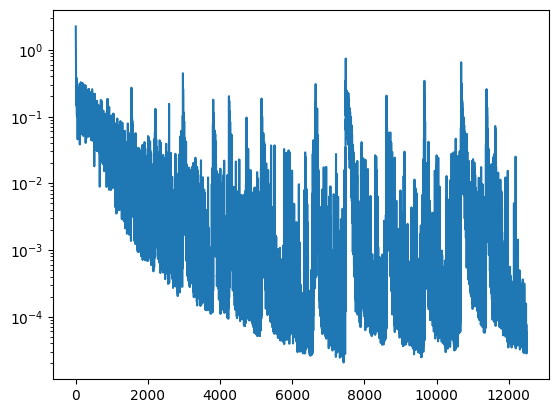

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.semilogy(results['train_loss'])

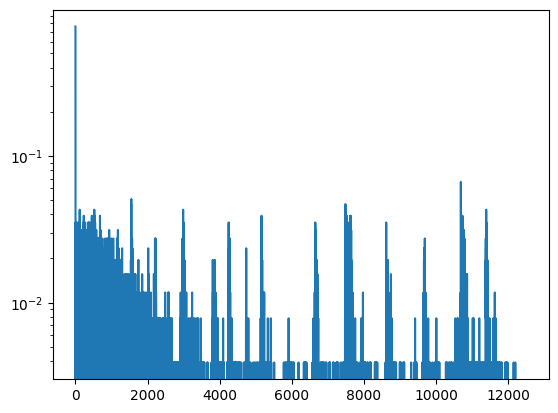

In [57]:
import numpy as np
plt.semilogy(1 - np.array(results['train_IIA']))

In [58]:
results['test_IIA']

0.99999375

In [79]:
from functools import partial
from siit_utils import make_post_ablation_hook
tot = 0
errors = 0
ablated_errors = 0
for b in trainer.test_dataloaders[0]:
    tokens, labels = b
    logits, cache = ll_model.run_with_cache(tokens)
    output_labels = t.round(t.sigmoid(logits)[:,-1,-1])
    sumdiff = (labels.cuda() != output_labels.float()).sum().item()

    hooks = []
    for node in unused_nodes:
        hooks.append((node.name, make_post_ablation_hook(ll_node=node, ll_cache=cache, method='mean')))
    ablated_logits = ll_model.run_with_hooks(tokens, fwd_hooks=hooks)
    
    ablated_labels = t.round(t.sigmoid(ablated_logits)[:,-1,-1])
    ablated_sumdiff = (labels.cuda() != ablated_labels.float()).sum().item()

    errors += sumdiff
    ablated_errors += ablated_sumdiff
    tot += labels.numel()
print(f'Errors: {errors}/{tot}, Ablated Err: {ablated_errors}/{tot}')
    

Errors: 1/160000, Ablated Err: 16/160000


In [ ]:
    
for idx in range(100):
    tokens, label = test_t_dataset[idx]
    output_label = t.sigmoid(ll_model(tokens))
    output, cache = ll_model.run_with_cache(tokens)
    ablated_output = t.sigmoid(ll_model.run_with_hooks(tokens, fwd_hooks=[
        (node.name, make_post_ablation_hook(node, cache, method='mean')) for node in unused_hook_nodes
    ]))
    if label.item() == 1:
        print(label.item(), f'{output_label[0,-1].item():.2e}, {ablated_output[0,-1].item():.2e}', tokens)
    elif idx % 10 == 0:
        print(label.item(), f'{output_label[0,-1].item():.2e}, {ablated_output[0,-1].item():.2e}',)

In [7]:
#TODO: Add lines to save model to huggingface.

# SAE

In [8]:
from paren_checker import create_paren_checker_tokenizer
tokenizer = create_paren_checker_tokenizer()
ll_model.tokenizer = tokenizer #attach to model.

Encoded: [0, 1, 2, 1, 2, 3, 3, 3]
Decoded: BOS ( ) ( ) [PAD] [PAD] [PAD]


In [37]:
from sae_utils import make_sae_lens_config
sae_lens_cfg = make_sae_lens_config(
    model=ll_model, 
    hook_name="blocks.0.mlp.hook_post", 
    hook_layer=0, 
    l1_coeff=0.4,
    # hook_head_index=0, 
    context_size=ll_model.cfg.n_ctx,
    d_in=ll_model.cfg.d_mlp,
    device = 'cuda',
    checkpoint_path = f"$HOME/persistent-storage/tracr_saes/parens_sae_checkpoints",
    wandb_project =  "benchmark_saes",
    training_tokens = 200_000_000
)

context_size 20
d_in 64
wandb_project benchmark_saes
Run name: 256-L1-0.4-LR-0.0003-Tokens-2.000e+08
n_tokens_per_buffer (millions): 0.0016
Lower bound: n_contexts_per_buffer (millions): 8e-05
Total training steps: 2500000
Total wandb updates: 250000
n_tokens_per_feature_sampling_window (millions): 3.2
n_tokens_per_dead_feature_window (millions): 1.6
We will reset the sparsity calculation 1250 times.
Number tokens in sparsity calculation window: 1.60e+05
Using Ghost Grads.


In [38]:
from sae_utils import train_sae

#I need to be able to tell the SAE to ignore certain tokens during training.
sae, store = train_sae(ll_model, sae_lens_cfg, dataset, batch_size=256, ignore_tokens=[0, 3])

Training SAE:   0%|                                                                         | 0/200000000 [00:00<?, ?it/s]/workspace/quick-experiments/sae_utils.py:316: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t.tensor(dataset['tokens']).int(),
8800| MSE Loss 0.155 | L1 1.740:  20%|██████▉                            | 39849676/200000000 [01:56<07:27, 357848.64it/s]

saving $HOME/persistent-storage/tracr_saes/parens_sae_checkpoints/h8wmxbl2/40003721


17600| MSE Loss 0.140 | L1 1.700:  40%|█████████████▌                    | 79701938/200000000 [03:56<06:02, 331966.91it/s]

saving $HOME/persistent-storage/tracr_saes/parens_sae_checkpoints/h8wmxbl2/80000727


26400| MSE Loss 0.135 | L1 1.682:  60%|███████████████████▋             | 119551404/200000000 [05:51<03:45, 357448.92it/s]

saving $HOME/persistent-storage/tracr_saes/parens_sae_checkpoints/h8wmxbl2/120004194


35300| MSE Loss 0.127 | L1 1.655:  80%|██████████████████████████▍      | 159855130/200000000 [07:52<01:58, 340018.63it/s]

saving $HOME/persistent-storage/tracr_saes/parens_sae_checkpoints/h8wmxbl2/160000025


44100| MSE Loss 0.126 | L1 1.663: 100%|████████████████████████████████▉| 199706082/200000000 [09:46<00:00, 356473.37it/s]

saving $HOME/persistent-storage/tracr_saes/parens_sae_checkpoints/h8wmxbl2/final_200000495


44100| MSE Loss 0.126 | L1 1.663: 100%|████████████████████████████████▉| 199706082/200000000 [09:47<00:00, 339824.59it/s]


details/current_l1_coefficient,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
details/current_learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
details/n_training_tokens,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
losses/auxiliary_reconstruction_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
losses/ghost_grad_loss,█▅▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
losses/l1_loss,█▅▃▂▂▂▂▂▂▁▂▁▁▁▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
losses/mse_loss,█▅▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
losses/overall_loss,█▅▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
metrics/explained_variance,▁▅▆▇▇▇▇▇█▇█▇▇▇██████▇███████████████████
metrics/explained_variance_std,█▄▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
metrics/l0,█▆▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [39]:
from sae_utils import make_token_df
from torch.utils.data import DataLoader, TensorDataset

n_activations_sum = t.zeros(sae.cfg.d_sae).to(sae.device)
input_tokens_list = []
learned_activations = []

small_dataset = ParensBalanceDataset(N_samples=10_000, n_ctx=20).get_dataset()
small_dataset = TensorDataset(
    t.tensor(small_dataset['tokens']).int(), 
    t.tensor(small_dataset['labels']).float()
)
dataloader  = DataLoader(small_dataset, batch_size=256, shuffle = False)

# small_trainer = ModelTrainerSIIT(
#     ll_model=ll_model,
#     hl_model=balance_checker,
#     dataset=small_dataset,
#     corr=corr,
#     unused_nodes=unused_nodes,
#     loss_fn=loss_fn,
#     baseline_weight = 1,
#     iit_weight = 1,
#     siit_weight = 1,
#     batch_size = 256,
#     device = 'cuda'
# )

#go through the training dataset and get max activations for each feature
total_inputs = 0
for batch in dataloader:
    tokens, labels = batch
    total_inputs += tokens.numel()
    logits, cache = ll_model.run_with_cache(tokens)
    sae_in = cache[sae.cfg.hook_name]
    if sae.cfg.hook_head_index is not None:
        sae_in = sae_in[:,:,sae.cfg.hook_head_index,:] #I think this is how attn head indexing works...
    activations = sae.encode(sae_in)
    # print(activations.shape, labels.shape, tokens.shape, tokens.numel())
    activations[t.isin(tokens.int(), t.Tensor([0, 3]).int())] = 0

    # For sparsity calculation
    n_new_activations = (activations > 0).sum(dim=(0,1)) #sum over batch and ctx
    n_activations_sum = n_activations_sum + n_new_activations

    # Save tokens and activations
    input_tokens_list.append(tokens.cpu())
    learned_activations.append(activations.to(t.float16).cpu().reshape(-1, sae.cfg.d_sae))

    if total_inputs > 1_000_000:
        break
sparsity = n_activations_sum / total_inputs
tokens = t.cat(input_tokens_list).to(int)
token_df = make_token_df(ll_model, tokens, len_prefix=ll_model.cfg.n_ctx)
learned_activations = t.cat(learned_activations).to(t.float16)
token_df.shape

tokens torch.Size([10000, 20])


(200000, 8)

In [40]:
print(type(token_df['prefix'][10]))
print(type(token_df['str_tokens'][10]))

<class 'str'>
<class 'str'>


In [41]:
from transformer_lens import utils
import ipywidgets as widgets
from IPython.display import display

def update_dataframe(feature_id):
    token_df["activation"] = utils.to_numpy(learned_activations[:,feature_id])
    df = token_df[['str_tokens','prefix', 'suffix',  'context', 'activation']]
    df = df.sort_values("activation", ascending=False).head(100)
    unique = df[['str_tokens', 'prefix', 'activation']].drop_duplicates()
    display(unique[unique['activation'] > 0].head(100).style.background_gradient("coolwarm"))

# Define the dropdown menu for 'feat'
feat_dropdown = widgets.Dropdown(
    options=range(sae.cfg.d_sae),
    value=0,
    description='Feature:',
)

# Create an interactive output widget
output = widgets.interactive_output(
    update_dataframe, 
    {
        'feature_id': feat_dropdown,
    }
)

# Display the dropdown menu and output
display(feat_dropdown, output)



Dropdown(description='Feature:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…

Output()

sae for attn 0:

0. Weak version of 3
1. ) after BOS, ele = -1
2. ( after BOS, ele = 2
3. ) after BOS)))), ele = -5
4. PAD
5. PAD
6. BOS
7. ) on a long sequence like BOS))))))))))) (very negative elevation
8. dead?
9. Weak ) after BOS))))), ele=-6
10. ) after BOS, ele = -1
11. ( after BOS((((, ele=5
12. same as 11
13. same as 3
14. ( after something like BOS))))))))))
15. same as 3
16. Weak ) after BOS)), ele=-3
17. Same as 3
18. Same as 7
19. weak last-token-position feature
20. ( after BOS (same as 2)
21. Same as 7
22. Same as 11
23. Dead
24. Same as 1
25. PAD
26. PAD
27. weak polysemantic feature?
28. ( after BOS(((((( (very positive elevation)
29. PAD
30. same as 3
31. same as 3

OK but none of these has any () () types of features which would be important for elevation...

In [70]:
print(sparsity)

tensor([8.1204e-03, 1.7862e-02, 1.0876e-01, 1.1166e-01, 1.6261e-01, 1.2456e-04,
        2.0000e-01, 4.0609e-01, 0.0000e+00, 8.7565e-02, 2.8484e-02, 3.2870e-01,
        1.0235e-01, 7.1886e-02, 1.1990e-02, 5.4087e-01, 1.6762e-02, 2.7499e-02,
        1.0810e-01, 4.0856e-05, 1.5344e-01, 5.2172e-01, 2.8940e-01, 0.0000e+00,
        4.0261e-02, 3.9381e-03, 7.3113e-03, 4.5251e-03, 2.3200e-01, 4.3447e-04,
        3.5353e-02, 2.6965e-02], device='cuda:0')


torch.Size([1003520, 32])
